# Testing RZX calibrations

This is a test for [an issue I opened in qiskit-terra](https://github.com/Qiskit/qiskit-terra/issues/7325).

In [1]:
import numpy as np
import pprint
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, schedule, IBMQ
from qiskit.circuit import Parameter
from qiskit.tools import job_monitor
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.transpiler import PassManager, passes
from qiskit.transpiler.passes.optimization.echo_rzx_weyl_decomposition import EchoRZXWeylDecomposition
from qiskit.circuit.library.standard_gates.equivalence_library import StandardEquivalenceLibrary as std_eqlib

from my_builder import RZXCalibrationBuilderWithPedestal

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibmq_bogota')

In [3]:
rzx_basis = ['rzx', 'rz', 'x', 'sx']

qiskit_pm = PassManager([
    passes.Collect2qBlocks(),
    passes.ConsolidateBlocks(basis_gates=['rz', 'sx', 'x', 'rzx']),            
    #EchoRZXWeylDecomposition(backend),
    passes.RZXCalibrationBuilderNoEcho(backend),
    passes.UnrollCustomDefinitions(std_eqlib, rzx_basis),
    passes.BasisTranslator(std_eqlib, rzx_basis),
    passes.Optimize1qGatesDecomposition(rzx_basis),
])

my_pm = PassManager([
    passes.Collect2qBlocks(),
    passes.ConsolidateBlocks(basis_gates=['rz', 'sx', 'x', 'rzx']),            
    #EchoRZXWeylDecomposition(backend),
    RZXCalibrationBuilderWithPedestal(backend),
    passes.UnrollCustomDefinitions(std_eqlib, rzx_basis),
    passes.BasisTranslator(std_eqlib, rzx_basis),
    passes.Optimize1qGatesDecomposition(rzx_basis),
])

In [4]:
qiskit_circuits = []
my_circuits = []
for itheta, theta in enumerate(np.linspace(np.pi / 32., np.pi, 30)):
    circuit = QuantumCircuit(2)
    circuit.x(1)
    circuit.rzx(-theta / 2., 1, 0)
    circuit.x(1)
    circuit.rzx(theta / 2., 1, 0)
    circuit.measure_all()
    
    qiskit_circuits.append(schedule(qiskit_pm.run(circuit), backend=backend))
    my_circuits.append(schedule(my_pm.run(circuit), backend=backend))

In [5]:
job = backend.run(qiskit_circuits + my_circuits, shots=10000)
job_monitor(job)

/usr/local/lib/python3.8/dist-packages/qiskit/compiler/assembler.py:447: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job has successfully run


In [6]:
result = job.result()
qiskit_counts = result.get_counts()[:30]
my_counts = result.get_counts()[30:]

In [7]:
import matplotlib.pyplot as plt

In [8]:
thetas = np.linspace(np.pi / 32., np.pi, 30)


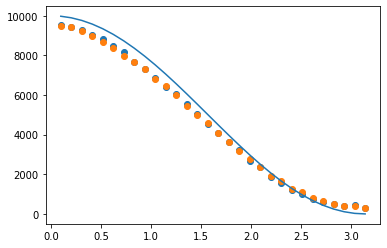

In [11]:
plt.scatter(thetas, np.array([c.get('00', 0) for c in qiskit_counts]))
plt.scatter(thetas, np.array([c.get('00', 0) for c in my_counts]))
plt.plot(thetas, 10000 * (0.5 * np.cos(thetas) + 0.5))